# Classification de commentaires à l'aide de l'apprentissage profond
D'Hondt Baptiste et Meurant Edouard

# Importation des packages

In [ ]:
import matplotlib.pyplot as plt

from time import time
import numpy as np
import pandas as pd
import tensorflow as tf

# Import Regex to clean up comments
import re

import nltk, string
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

# Get Reviews
import requests
import json

# Get comments
import httplib2
import requests
import urllib3

# TF IDF Imports

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from scipy.sparse import csc_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from joblib import dump, load
import seaborn as sns
from wordcloud import WordCloud

# RNN & LSTM Imports

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Bidirectional, Dense, LSTM, GlobalMaxPooling1D, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import random

# Importation des données

Ajoutez un raccourci de ce dossier à votre google drive :

https://drive.google.com/drive/folders/1mx-CAzT10YKrmxHfYDP_1Oef7PVGUr7s?usp=sharing

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/data_classification_commentaires_toxiques/train.csv')
print(f"{data[50:60]}")

                  id                                       comment_text  \
50  001d8e7be417776a  "\n\nBI, you said you wanted to talk\n\nAt the...   
51  001dc38a83d420cf  GET FUCKED UP. GET FUCKEEED UP.  GOT A DRINK T...   
52  001e89eb3f0b0915  Are you threatening me for disputing neutralit...   
53  001ee16c46a99262  Thanks! Undeletion was more than I'd hoped for...   
54  001ffdcc3e7fb49c  Awesome! Then I'll simply disregard your notic...   
55  0020e7119b96eeeb  Stupid peace of shit stop deleting my stuff as...   
56  0020fd96ed3b8c8b  =Tony Sidaway is obviously a fistfuckee. He lo...   
57  00218d74784ce50b  "\n\n GA Review II \n\nI'm sorry to say this, ...   
58  0021fe88bc4da3e6  My Band Page's deletion. You thought I was gon...   
59  002264ea4d5f2887  Why can't you believe how fat Artie is? Did yo...   

    toxic  severe_toxic  obscene  threat  insult  identity_hate  
50      0             0        0       0       0              0  
51      1             0        1       0  

Nous pouvons voir que les commentaires contiennent des mentions, des urls, etc. qui ne sont pas utiles pour le modèle de langage.

Nous devons donc nettoyer leur contenu.

Pour ce faire, réutilisons le nettoyage de tweet que nous avons vu dans Sentiment_analysis_avec_TensorFlow

# Préparation du jeu de données / Data cleaning

---



In [ ]:
tokenizer = TweetTokenizer(strip_handles=True)
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')
corpus = []

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Je crée une fonction pour nettoyer les commentaires. Les contractions sont séparées, les caractères spéciaux sont supprimés, ainsi que les URL, les mentions, les mots trop courts et les mots vides.

In [ ]:
def clean(comment):

    # Contractions
    comment = re.sub(r"he's", "he is", comment)
    comment = re.sub(r"there's", "there is", comment)
    comment = re.sub(r"We're", "We are", comment)
    comment = re.sub(r"That's", "That is", comment)
    comment = re.sub(r"won't", "will not", comment)
    comment = re.sub(r"they're", "they are", comment)
    comment = re.sub(r"Can't", "Cannot", comment)
    comment = re.sub(r"wasn't", "was not", comment)
    comment = re.sub(r"don\x89Ûªt", "do not", comment)
    comment = re.sub(r"aren't", "are not", comment)
    comment = re.sub(r"isn't", "is not", comment)
    comment = re.sub(r"What's", "What is", comment)
    comment = re.sub(r"haven't", "have not", comment)
    comment = re.sub(r"hasn't", "has not", comment)
    comment = re.sub(r"There's", "There is", comment)
    comment = re.sub(r"He's", "He is", comment)
    comment = re.sub(r"It's", "It is", comment)
    comment = re.sub(r"You're", "You are", comment)
    comment = re.sub(r"I'M", "I am", comment)
    comment = re.sub(r"shouldn't", "should not", comment)
    comment = re.sub(r"wouldn't", "would not", comment)
    comment = re.sub(r"i'm", "I am", comment)
    comment = re.sub(r"I\x89Ûªm", "I am", comment)
    comment = re.sub(r"I'm", "I am", comment)
    comment = re.sub(r"Isn't", "is not", comment)
    comment = re.sub(r"Here's", "Here is", comment)
    comment = re.sub(r"you've", "you have", comment)
    comment = re.sub(r"you\x89Ûªve", "you have", comment)
    comment = re.sub(r"we're", "we are", comment)
    comment = re.sub(r"what's", "what is", comment)
    comment = re.sub(r"couldn't", "could not", comment)
    comment = re.sub(r"we've", "we have", comment)
    comment = re.sub(r"it\x89Ûªs", "it is", comment)
    comment = re.sub(r"doesn\x89Ûªt", "does not", comment)
    comment = re.sub(r"It\x89Ûªs", "It is", comment)
    comment = re.sub(r"Here\x89Ûªs", "Here is", comment)
    comment = re.sub(r"who's", "who is", comment)
    comment = re.sub(r"I\x89Ûªve", "I have", comment)
    comment = re.sub(r"y'all", "you all", comment)
    comment = re.sub(r"can\x89Ûªt", "cannot", comment)
    comment = re.sub(r"would've", "would have", comment)
    comment = re.sub(r"it'll", "it will", comment)
    comment = re.sub(r"we'll", "we will", comment)
    comment = re.sub(r"wouldn\x89Ûªt", "would not", comment)
    comment = re.sub(r"We've", "We have", comment)
    comment = re.sub(r"he'll", "he will", comment)
    comment = re.sub(r"Y'all", "You all", comment)
    comment = re.sub(r"Weren't", "Were not", comment)
    comment = re.sub(r"Didn't", "Did not", comment)
    comment = re.sub(r"they'll", "they will", comment)
    comment = re.sub(r"they'd", "they would", comment)
    comment = re.sub(r"DON'T", "DO NOT", comment)
    comment = re.sub(r"That\x89Ûªs", "That is", comment)
    comment = re.sub(r"they've", "they have", comment)
    comment = re.sub(r"i'd", "I would", comment)
    comment = re.sub(r"should've", "should have", comment)
    comment = re.sub(r"You\x89Ûªre", "You are", comment)
    comment = re.sub(r"where's", "where is", comment)
    comment = re.sub(r"Don\x89Ûªt", "Do not", comment)
    comment = re.sub(r"we'd", "we would", comment)
    comment = re.sub(r"i'll", "I will", comment)
    comment = re.sub(r"weren't", "were not", comment)
    comment = re.sub(r"They're", "They are", comment)
    comment = re.sub(r"Can\x89Ûªt", "Cannot", comment)
    comment = re.sub(r"you\x89Ûªll", "you will", comment)
    comment = re.sub(r"I\x89Ûªd", "I would", comment)
    comment = re.sub(r"let's", "let us", comment)
    comment = re.sub(r"it's", "it is", comment)
    comment = re.sub(r"can't", "cannot", comment)
    comment = re.sub(r"don't", "do not", comment)
    comment = re.sub(r"you're", "you are", comment)
    comment = re.sub(r"i've", "I have", comment)
    comment = re.sub(r"that's", "that is", comment)
    comment = re.sub(r"i'll", "I will", comment)
    comment = re.sub(r"doesn't", "does not", comment)
    comment = re.sub(r"i'd", "I would", comment)
    comment = re.sub(r"didn't", "did not", comment)
    comment = re.sub(r"ain't", "am not", comment)
    comment = re.sub(r"you'll", "you will", comment)
    comment = re.sub(r"I've", "I have", comment)
    comment = re.sub(r"Don't", "do not", comment)
    comment = re.sub(r"I'll", "I will", comment)
    comment = re.sub(r"I'd", "I would", comment)
    comment = re.sub(r"Let's", "Let us", comment)
    comment = re.sub(r"you'd", "You would", comment)
    comment = re.sub(r"It's", "It is", comment)
    comment = re.sub(r"Ain't", "am not", comment)
    comment = re.sub(r"Haven't", "Have not", comment)
    comment = re.sub(r"Could've", "Could have", comment)
    comment = re.sub(r"youve", "you have", comment)
    comment = re.sub(r"donå«t", "do not", comment)

    comment = re.sub(r"some1", "someone", comment)
    comment = re.sub(r"yrs", "years", comment)
    comment = re.sub(r"hrs", "hours", comment)
    comment = re.sub(r"2morow|2moro", "tomorrow", comment)
    comment = re.sub(r"2day", "today", comment)
    comment = re.sub(r"4got|4gotten", "forget", comment)
    comment = re.sub(r"b-day|bday", "b-day", comment)
    comment = re.sub(r"mother's", "mother", comment)
    comment = re.sub(r"mom's", "mom", comment)
    comment = re.sub(r"dad's", "dad", comment)
    comment = re.sub(r"hahah|hahaha|hahahaha", "haha", comment)
    comment = re.sub(r"lmao|lolz|rofl", "lol", comment)
    comment = re.sub(r"thanx|thnx", "thanks", comment)
    comment = re.sub(r"goood", "good", comment)
    comment = re.sub(r"some1", "someone", comment)
    comment = re.sub(r"some1", "someone", comment)
    # Character entity references
    comment = re.sub(r"&gt;", ">", comment)
    comment = re.sub(r"&lt;", "<", comment)
    comment = re.sub(r"&amp;", "&", comment)
    # Typos, slang and informal abbreviations
    comment = re.sub(r"w/e", "whatever", comment)
    comment = re.sub(r"w/", "with", comment)
    comment = re.sub(r"<3", "love", comment)
    # Urls
    comment = re.sub(r"http\S+", "", comment)
    # Numbers
    comment = re.sub(r'[0-9]', '', comment)
    # Eliminating the mentions
    comment = re.sub("(@[A-Za-z0-9_]+)","", comment)
    # Remove punctuation and special chars (keep '!')
    for p in string.punctuation.replace('!', ''):
        comment = comment.replace(p, '')

    # ... and ..
    comment = comment.replace('...', ' ... ')
    if '...' not in comment:
        comment = comment.replace('..', ' ... ')

    # Tokenize
    comment_words = tokenizer.tokenize(comment)

    # Eliminating the word if its length is less than 3
    comment = [w for w in comment_words if len(w)>2]

    # remove stopwords
    comment = [w.lower() for w in comment if not w in stop_words]

    corpus.append(comment)

    # join back
    comment = ' '.join(comment)


    return comment

Les abréviations seront remplacées par leur équivalent complet grâce à ce dictionnaire d'abréviations et à la fonction convert_abbrev_in_text associée

In [ ]:
variable_name = ""
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk",
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart",
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life recomment",
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "recomment",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
     "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously",
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "comment me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

def convert_abbrev_in_text(comment):
    t=[]
    words=comment.split()
    t = [abbreviations[w.lower()] if w.lower() in abbreviations.keys() else w for w in words]
    return ' '.join(t)

La fonction suivante exécute les deux fonctions définies ci-dessus sur un commentaire donné :

In [ ]:
def prepare_string(comment):
  comment = clean(comment)
  comment = convert_abbrev_in_text(comment)
  return comment

Cette étape applique la fonction de nettoyage à tous les commentaires du corpus de texte et supprime les lignes qui sont vides après le nettoyage.



In [ ]:
%%time
# Apply prepare_string to all rows in 'tweets' column
data['comment_text'] = data['comment_text'].apply(lambda s : prepare_string(s))

# Drop empty values from dataframe
data['comment_text'].replace('', np.nan, inplace=True)
data.dropna(subset=['comment_text'], inplace=True)

CPU times: user 2min 15s, sys: 837 ms, total: 2min 16s
Wall time: 2min 38s


Le DataFrame résultant est converti en CSV et téléchargé afin d'éviter la réexécution du code précédent qui consomme beaucoup de ressources et de temps.

In [ ]:
#data.to_csv('/content/drive/MyDrive/data_project_nlp.csv', index=False)
data = pd.read_csv('/content/drive/MyDrive/data_project_nlp.csv')

In [ ]:
np.shape(data)

(159513, 8)

In [ ]:
print(f"{data[50:60]}")

                  id                                       comment_text  \
50  001d8e7be417776a  said wanted talk bottom lead section written i...   
51  001dc38a83d420cf  get fucked get fuckeeed got drink that you can...   
52  001e89eb3f0b0915  are threatening disputing neutrality know coun...   
53  001ee16c46a99262  thanks undeletion would hoped researching stat...   
54  001ffdcc3e7fb49c        awesome then simply disregard notice thanks   
55  0020e7119b96eeeb  stupid peace shit stop deleting stuff asshole ...   
56  0020fd96ed3b8c8b    tony sidaway obviously fistfuckee loves arm ass   
57  00218d74784ce50b  review sorry say fail articles gan the several...   
58  0021fe88bc4da3e6  band pages deletion you thought gone deleting ...   
59  002264ea4d5f2887  why cannot believe fat artie did see recent ap...   

    toxic  severe_toxic  obscene  threat  insult  identity_hate  
50      0             0        0       0       0              0  
51      1             0        1       0  

# Data Visualisation

**Distribution des classes** : Affiche un diagramme à barres pour montrer la répartition des classes (toxic, severe_toxic, obscene, threat, insult, identity_hate). Cela donne une idée du déséquilibre des données.

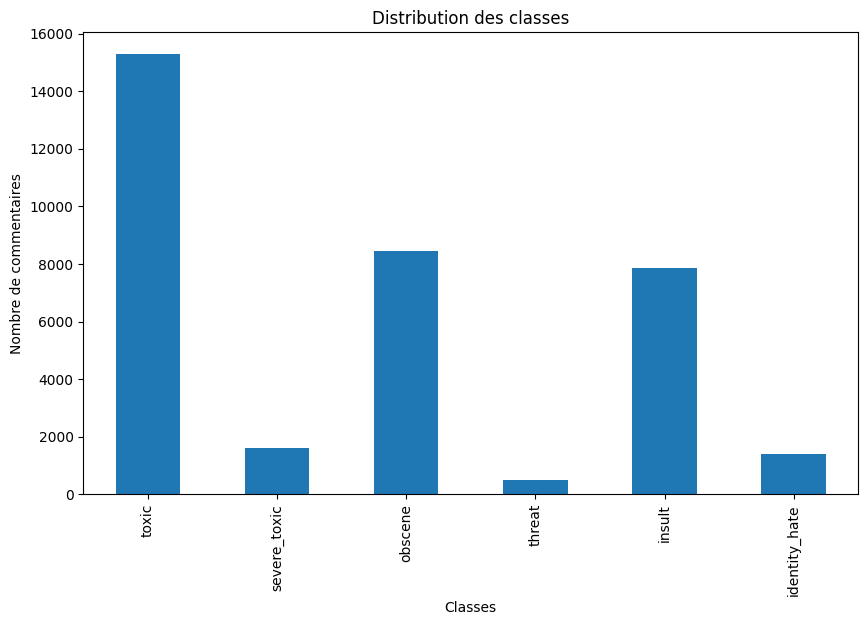

In [ ]:
class_distribution = data.iloc[:, 2:].sum()
class_distribution.plot(kind='bar', figsize=(10, 6), title='Distribution des classes')
plt.xlabel('Classes')
plt.ylabel('Nombre de commentaires')
plt.show()

**Nuage de mots** : Crée un nuage de mots pour chaque classe afin de visualiser les termes les plus fréquents associés à chaque catégorie.

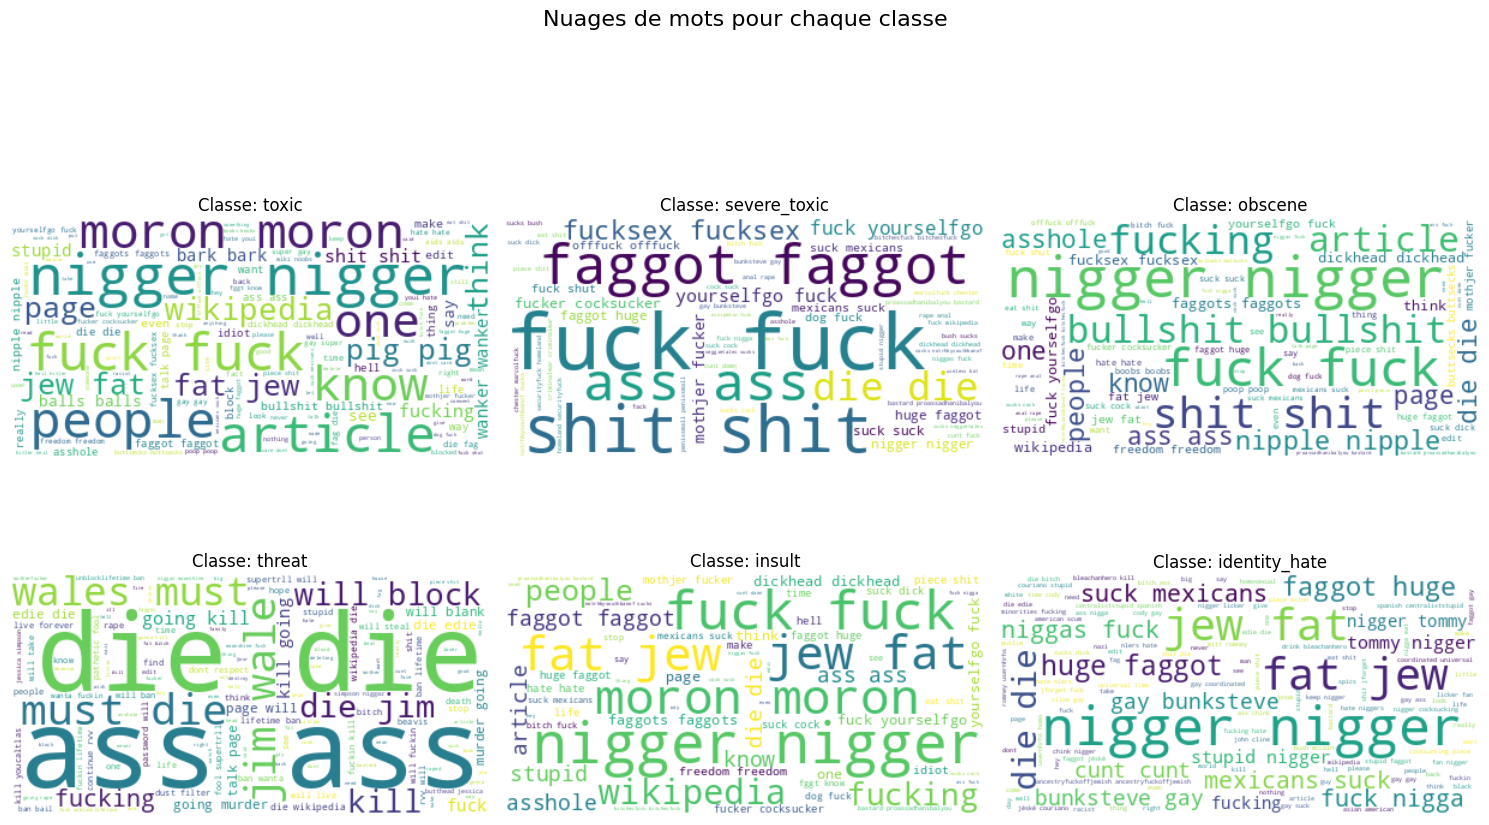

In [ ]:
# Créer une disposition de sous-graphiques 2x3 pour les 6 classes
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Nuages de mots pour chaque classe', fontsize=16)

# Classes à visualiser
classes_to_visualize = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Parcourir les classes et créer les nuages de mots
for i, label in enumerate(classes_to_visualize):
    row, col = i // 3, i % 3
    subset_comments = data[data[label] == 1]['comment_text']

    wordcloud = WordCloud(width=400, height=200, max_words=150, background_color='white').generate(' '.join(subset_comments))

    axes[row, col].imshow(wordcloud, interpolation='bilinear')
    axes[row, col].set_title(f'Classe: {label}')
    axes[row, col].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

**Longueur des commentaires** : Explore la distribution des longueurs de commentaires pour chaque classe.

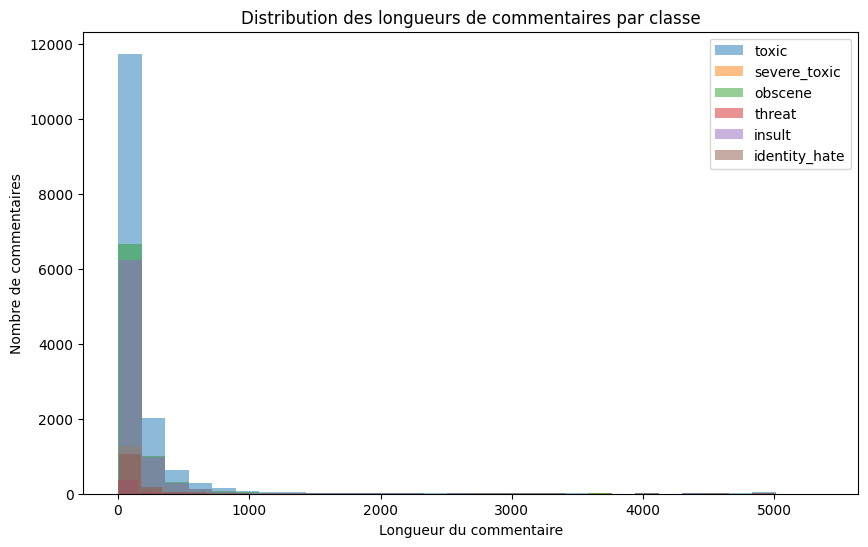

In [ ]:
data['comment_length'] = data['comment_text'].apply(len)
plt.figure(figsize=(10, 6))
for label in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']:
    subset = data[data[label] == 1]
    plt.hist(subset['comment_length'], bins=30, alpha=0.5, label=label)

plt.title('Distribution des longueurs de commentaires par classe')
plt.xlabel('Longueur du commentaire')
plt.ylabel('Nombre de commentaires')
plt.legend(loc='upper right')
plt.show()


**Corrélation entre les classes** : Explore la corrélation entre les différentes classes pour comprendre si certaines classes sont souvent associées.

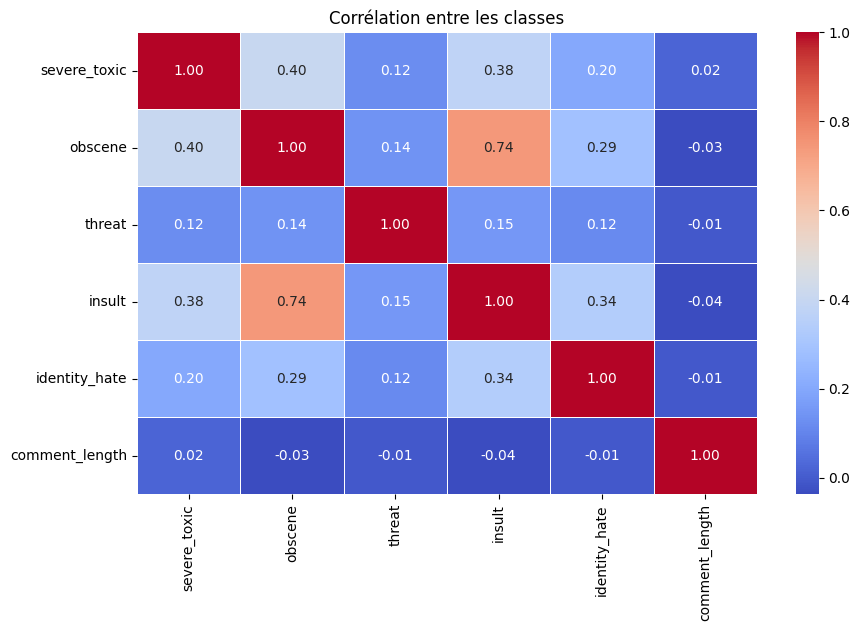

In [ ]:
correlation_matrix = data.iloc[:, 3:].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Corrélation entre les classes')
plt.show()


On enregistre un copie du data frame pour garder l'original en mémoire

In [ ]:
gu = data.copy()
print(f"{gu[50:60]}")

                  id                                       comment_text  \
50  001d8e7be417776a  said wanted talk bottom lead section written i...   
51  001dc38a83d420cf  get fucked get fuckeeed got drink that you can...   
52  001e89eb3f0b0915  are threatening disputing neutrality know coun...   
53  001ee16c46a99262  thanks undeletion would hoped researching stat...   
54  001ffdcc3e7fb49c        awesome then simply disregard notice thanks   
55  0020e7119b96eeeb  stupid peace shit stop deleting stuff asshole ...   
56  0020fd96ed3b8c8b    tony sidaway obviously fistfuckee loves arm ass   
57  00218d74784ce50b  review sorry say fail articles gan the several...   
58  0021fe88bc4da3e6  band pages deletion you thought gone deleting ...   
59  002264ea4d5f2887  why cannot believe fat artie did see recent ap...   

    toxic  severe_toxic  obscene  threat  insult  identity_hate  
50      0             0        0       0       0              0  
51      1             0        1       0  

Pour l'instant, nous classerons simplement les commentaires en fonction de s'ils sont toxiques ou non. Par la suite, si la classification est pertinente, nous ajouterons les différentes classes. Pour cela, nous préparons le dataset à ne contenir qu'une classe "Toxique"

In [ ]:
# Créer la nouvelle colonne "toxique" en fusionnant toutes les classes
gu['toxique'] = gu['toxic'] | gu['severe_toxic'] | gu['obscene'] | gu['threat'] | gu['insult'] | gu['identity_hate']

gu.drop(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'], axis=1, inplace=True)

print(f"{gu[50:60]}")


                  id                                       comment_text  \
50  001d8e7be417776a  said wanted talk bottom lead section written i...   
51  001dc38a83d420cf  get fucked get fuckeeed got drink that you can...   
52  001e89eb3f0b0915  are threatening disputing neutrality know coun...   
53  001ee16c46a99262  thanks undeletion would hoped researching stat...   
54  001ffdcc3e7fb49c        awesome then simply disregard notice thanks   
55  0020e7119b96eeeb  stupid peace shit stop deleting stuff asshole ...   
56  0020fd96ed3b8c8b    tony sidaway obviously fistfuckee loves arm ass   
57  00218d74784ce50b  review sorry say fail articles gan the several...   
58  0021fe88bc4da3e6  band pages deletion you thought gone deleting ...   
59  002264ea4d5f2887  why cannot believe fat artie did see recent ap...   

    toxique  
50        0  
51        1  
52        0  
53        0  
54        0  
55        1  
56        1  
57        0  
58        1  
59        1  


# Entraînement du modèle baseline

In [ ]:
# Exemple d'utilisation avec vos commentaires nettoyés
corpus = gu['comment_text']

# Initialiser le vecteur TF-IDF
tfidf_vectorizer = TfidfVectorizer()

# Appliquer la tokenization et la transformation TF-IDF
tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)

# Afficher la taille de la matrice TF-IDF
print(f"Shape of TF-IDF matrix: {tfidf_matrix.shape}")


Shape of TF-IDF matrix: (159513, 217784)


In [ ]:
# On prend 15000 pour préserver la RAM
commentaires = gu.loc[:15000, 'comment_text']
y = gu.loc[:15000, 'toxique']

Utilisez la fonction TF-IDF de Sklearn.

In [ ]:
tfIdfVectorizer = TfidfVectorizer()
X = tfIdfVectorizer.fit_transform(commentaires).toarray()

Divisez votre ensemble de données de formation et de test à l'aide de la fonction sklearn.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.025, random_state=0)

Entraînez un modèle en utilisant la fonction de forêt aléatoire de sklearn.


In [ ]:
# Use only 15 estimator to save your ram
text_classifier = RandomForestClassifier(n_estimators=15, random_state=0)
text_classifier.fit(X_train, y_train )

RandomForestClassifier(n_estimators=15, random_state=0)

Calculer la prédiction sur l'ensemble de test.

In [ ]:
predictions = text_classifier.predict(X_test)

Calculer quelques mesures de performance :
- matrice de confusion
- rapport de classification
- précision

In [ ]:
print(confusion_matrix(y_test,predictions))

print(classification_report(y_test,predictions))

print(accuracy_score(y_test, predictions))

[[337   5]
 [ 14  20]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       342
           1       0.80      0.59      0.68        34

    accuracy                           0.95       376
   macro avg       0.88      0.79      0.83       376
weighted avg       0.95      0.95      0.95       376

0.949468085106383


Même principe en utilisant la fonction de régression logistique de sklearn sur l'ensemble des données

In [ ]:
# Diviser le jeu de données en ensembles d'entraînement (70%), de test (15%) et de validation (15%)
train_data, temp_data = train_test_split(data, test_size=0.3, random_state=42, stratify=data['toxique'])
valid_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42, stratify=temp_data['toxique'])

# Séparer les commentaires et les étiquettes
X_train, y_train = train_data['comment_text'], train_data['toxique']
X_valid, y_valid = valid_data['comment_text'], valid_data['toxique']
X_test, y_test = test_data['comment_text'], test_data['toxique']

# Initialiser le vecteur TF-IDF
tfidf_vectorizer = TfidfVectorizer()

# Appliquer la tokenization et la transformation TF-IDF sur les données d'entraînement
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Appliquer la transformation TF-IDF sur les données de validation et de test
X_valid_tfidf = tfidf_vectorizer.transform(X_valid)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Initialiser le modèle de régression logistique
logistic_model = LogisticRegression(random_state=42)

# Entraîner le modèle sur les données d'entraînement
logistic_model.fit(X_train_tfidf, y_train)

# Faire des prédictions sur les données de validation
y_valid_pred = logistic_model.predict(X_valid_tfidf)

# Évaluer les performances sur les données de validation
accuracy = accuracy_score(y_valid, y_valid_pred)
print(f"Accuracy on validation data: {accuracy:.4f}")

# Afficher le rapport de classification
print("Classification Report on validation data:")
print(classification_report(y_valid, y_valid_pred))

# Afficher la matrice de confusion
conf_matrix = confusion_matrix(y_valid, y_valid_pred)
print("Confusion Matrix on validation data:")
print(conf_matrix)


Accuracy on validation data: 0.9540
Classification Report on validation data:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     21494
           1       0.92      0.60      0.73      2433

    accuracy                           0.95     23927
   macro avg       0.94      0.80      0.85     23927
weighted avg       0.95      0.95      0.95     23927

Confusion Matrix on validation data:
[[21369   125]
 [  975  1458]]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# RNN & LSTM with GloVe

In [ ]:
corpus = list(zip(gu['comment_text'].values, gu['toxique'].values))

Hyperparamètres

In [ ]:
embedding_dim = 100    # Dimensions used for glove6b100
max_length = 50        # Maximum size of a comment
trunc_type='post'      # Truncates the tweet if it is longer than max_length
padding_type='post'    # Adds padding to the end of the tweet if it is shorter than max_length
oov_tok = "<OOV>"      # Token "<OOV>" replaces words that are not part of the vocabulary (Out Of Vocabulary)
training_size=len(corpus)
test_portion=.025

In [ ]:
corpus[55:60]

[('stupid peace shit stop deleting stuff asshole die fall hole hell', 1),
 ('tony sidaway obviously fistfuckee loves arm ass', 1),
 ('review sorry say fail articles gan the several major problems brought articles previous assessment issued said articles wplead longer the history media attention academics student government demographics trivia additional information section deficient citiations also triva additional information integrated rest article again please look wpwiaga fix problem renominate gaclass however reassessed article bclass meet bclass criteria regards',
  0),
 ('band pages deletion you thought gone deleting comment posted talk page delete feelings hasty decision delete page you sir still cocksucking douche fuck sit back second think life become done that take long nope because certainly aware life shitstorm sitting front computer masturbating fictional creatures your attempts get rid mediocre best you constantly sucking dick failure you want personal attack huh well ba

#### Distribution des données de test et d'entraînement

In [ ]:
sentences=[]
labels=[]

#### Mélange des données

In [ ]:
random.shuffle(corpus)

Séparation des labels et des tweets

In [ ]:
for x in range(training_size):
    sentences.append(str(corpus[x][0]))
    labels.append(corpus[x][1])

Tokenizer

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

Création du vecteur de mapping avec les mots de vocabulaire associés aux indices

In [ ]:
word_index = tokenizer.word_index
vocab_size=len(word_index)

Création de vecteurs d'indices à partir de commentaires

In [ ]:
sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

Création d'ensembles d'entraînement pour le réseau neuronal

In [ ]:
split = int(test_portion * training_size)

test_sequences = padded[0:split]
training_sequences = padded[split:training_size]
test_labels = labels[0:split]
training_labels = labels[split:training_size]

In [ ]:
# Save tokenizer for later
# dump(tokenizer, '/content/drive/MyDrive/RNNTokenizerProject.joblib')

['/content/drive/MyDrive/RNNTokenizerProject.joblib']

### Entraînement d'un modèle en utilisant embedding

In [ ]:
num_epochs = 7

training_padded = np.array(training_sequences)
training_labels = np.array(training_labels)
testing_padded = np.array(test_sequences)
testing_labels = np.array(test_labels)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length),
    LSTM(units=64),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
history = model.fit(training_padded,
                      training_labels,
                      epochs=num_epochs,
                      validation_data=(testing_padded, testing_labels),
                      batch_size = 256,
                      verbose=1)

print("Training Complete")

Epoch 1/7
608/608 [==============================] - 561s 917ms/step - loss: 0.2319 - accuracy: 0.9290 - val_loss: 0.1154 - val_accuracy: 0.9566
Epoch 2/7
608/608 [==============================] - 552s 908ms/step - loss: 0.0932 - accuracy: 0.9675 - val_loss: 0.1114 - val_accuracy: 0.9589
Epoch 3/7
608/608 [==============================] - 549s 903ms/step - loss: 0.0583 - accuracy: 0.9789 - val_loss: 0.1388 - val_accuracy: 0.9554
Epoch 4/7
608/608 [==============================] - 549s 903ms/step - loss: 0.0378 - accuracy: 0.9866 - val_loss: 0.1776 - val_accuracy: 0.9523
Epoch 5/7
608/608 [==============================] - 545s 896ms/step - loss: 0.0266 - accuracy: 0.9908 - val_loss: 0.1760 - val_accuracy: 0.9491
Epoch 6/7
608/608 [==============================] - 531s 873ms/step - loss: 0.0186 - accuracy: 0.9937 - val_loss: 0.2041 - val_accuracy: 0.9456
Epoch 7/7
608/608 [==============================] - 525s 863ms/step - loss: 0.0147 - accuracy: 0.9951 - val_loss: 0.2323 - val_ac

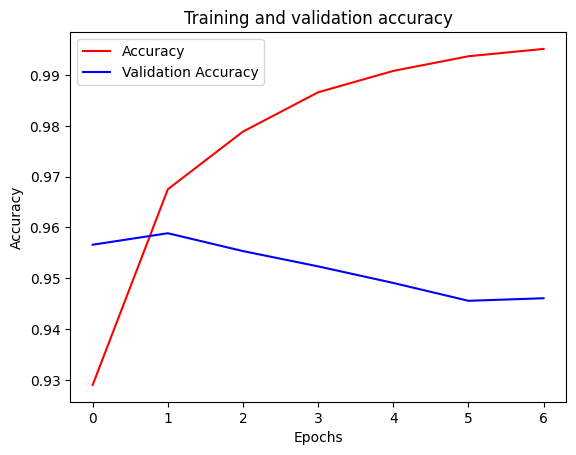

<Figure size 640x480 with 0 Axes>

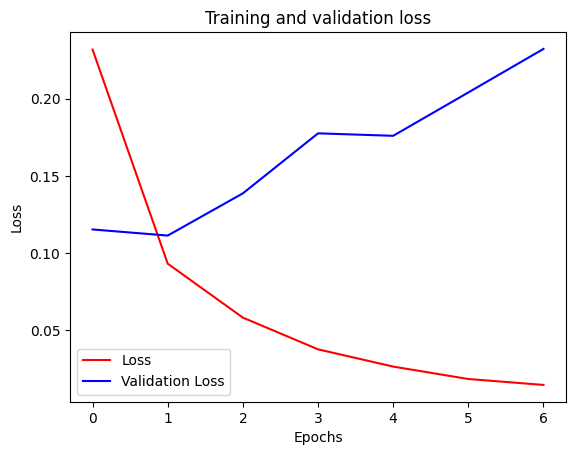

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt


#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()
plt.show()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()
plt.show()

Sauvegardez votre modèle en utilisant la méthode ``.save()``.

In [ ]:
model.save('/content/drive/MyDrive/RNN_project_nlp_model_train.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


125/125 [==============================] - 4s 20ms/step


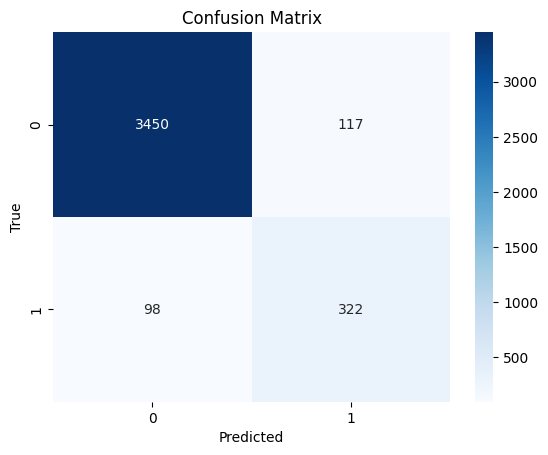

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      3567
           1       0.73      0.77      0.75       420

    accuracy                           0.95      3987
   macro avg       0.85      0.87      0.86      3987
weighted avg       0.95      0.95      0.95      3987



In [ ]:
# Effectuer des prédictions sur les données de test
predictions = model.predict(testing_padded)

# Convertir les prédictions en classes (0 ou 1)
predicted_labels = (predictions > 0.5).astype(int)

# Calculer la matrice de confusion
conf_matrix = confusion_matrix(testing_labels, predicted_labels)

# Afficher la matrice de confusion sous forme de heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Afficher le rapport de classification
print(classification_report(testing_labels, predicted_labels))

#### GLoVe : Création de la matrice d'embedding

In [ ]:
embeddings_index = {};

with open('/content/drive/MyDrive/RNN_sentiment_dataset/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

#### Création du réseau neuronal LSTM

En utilisant le séquentiel ([doc](https://keras.io/guides/sequential_model/)), initialiser un modèle d'apprentissage profond avec :
- une couche d'imbrication ([doc](https://keras.io/api/layers/core_layers/embedding/)) (input_dim=vocab_size+1, output_dim=embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False)
- LSTM ([doc](https://keras.io/api/layers/recurrent_layers/lstm/)) (unités=64)
- Dense ([doc](https://keras.io/api/layers/core_layers/dense/)) (unités=1)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    LSTM(units=64),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

Compilez votre modèle en utilisant la méthode ``.compile`` [doc](https://keras.io/api/models/model/) en utilisant les paramètres (loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

Utilisez la méthode ``.summary()`` à votre modèle pour le visualiser.

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 50, 100)           21780700  
                                                                 
 lstm_4 (LSTM)               (None, 64)                42240     
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 21823005 (83.25 MB)
Trainable params: 42305 (165.25 KB)
Non-trainable params: 21780700 (83.09 MB)
_________________________________________________________________


#### Entraînez votre modèle

In [ ]:
num_epochs = 7

training_padded = np.array(training_sequences)
training_labels = np.array(training_labels)
testing_padded = np.array(test_sequences)
testing_labels = np.array(test_labels)

Utilisez la méthode ``.fit`` pour entraîner votre modèle.

In [ ]:
history = model.fit(training_padded,
                      training_labels,
                      epochs=num_epochs,
                      validation_data=(testing_padded, testing_labels),
                      batch_size = 256,
                      verbose=1)

print("Training Complete")

Epoch 1/7
608/608 [==============================] - 96s 154ms/step - loss: 0.1841 - accuracy: 0.9369 - val_loss: 0.1465 - val_accuracy: 0.9448
Epoch 2/7
608/608 [==============================] - 92s 152ms/step - loss: 0.1271 - accuracy: 0.9541 - val_loss: 0.1266 - val_accuracy: 0.9513
Epoch 3/7
608/608 [==============================] - 88s 145ms/step - loss: 0.1171 - accuracy: 0.9577 - val_loss: 0.1243 - val_accuracy: 0.9536
Epoch 4/7
608/608 [==============================] - 84s 138ms/step - loss: 0.1105 - accuracy: 0.9601 - val_loss: 0.1204 - val_accuracy: 0.9561
Epoch 5/7
608/608 [==============================] - 91s 149ms/step - loss: 0.1061 - accuracy: 0.9616 - val_loss: 0.1230 - val_accuracy: 0.9533
Epoch 6/7
608/608 [==============================] - 90s 147ms/step - loss: 0.1020 - accuracy: 0.9630 - val_loss: 0.1180 - val_accuracy: 0.9571
Epoch 7/7
608/608 [==============================] - 86s 141ms/step - loss: 0.0991 - accuracy: 0.9645 - val_loss: 0.1161 - val_accuracy:

Sauvegardez votre modèle en utilisant la méthode ``.save()``.

In [ ]:
model.save('/content/drive/MyDrive/LSTM_project_nlp_model_train.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### Visualisation de l'entrainement

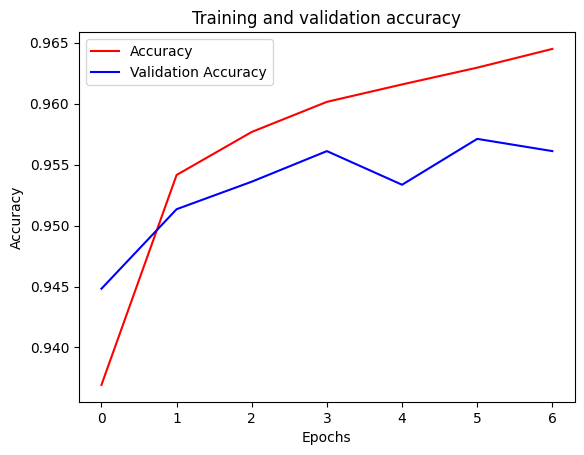

<Figure size 640x480 with 0 Axes>

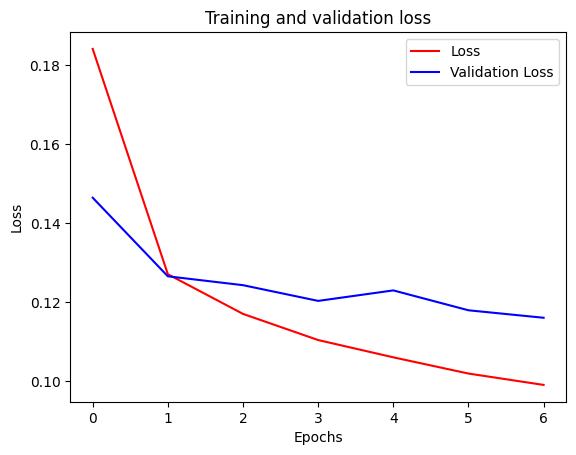

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt


#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()
plt.show()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()
plt.show()

#### Itération de la modélisation

125/125 [==============================] - 2s 12ms/step


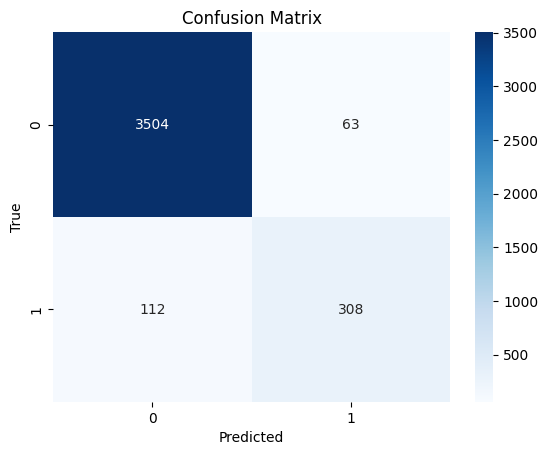

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      3567
           1       0.83      0.73      0.78       420

    accuracy                           0.96      3987
   macro avg       0.90      0.86      0.88      3987
weighted avg       0.95      0.96      0.95      3987



In [ ]:
# Effectuer des prédictions sur les données de test
predictions = model.predict(testing_padded)

# Convertir les prédictions en classes (0 ou 1)
predicted_labels = (predictions > 0.5).astype(int)

# Calculer la matrice de confusion
conf_matrix = confusion_matrix(testing_labels, predicted_labels)

# Afficher la matrice de confusion sous forme de heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Afficher le rapport de classification
print(classification_report(testing_labels, predicted_labels))


#### Entrainement d'un modèle similaire sur toutes les classes

#### Distribution des données de test et d'entraînement

In [ ]:
num_val_samples = int(0.15 * len(data))
num_train_samples = len(data) - 2 * num_val_samples
train_data = data[:num_train_samples]
val_data = data[num_train_samples:num_train_samples + num_val_samples]
test_data = data[num_train_samples + num_val_samples:]

print(f"{data.shape} total")
print(f"{train_data.shape} training")
print(f"{val_data.shape} validation")
print(f"{test_data.shape} test")

(159513, 8) total
(111661, 8) training
(23926, 8) validation
(23926, 8) test


Hyperparamètres

In [ ]:
embedding_dim = 100    # Dimensions used for glove6b100
max_length = 50        # Maximum size of a comment
trunc_type='post'      # Truncates the tweet if it is longer than max_length
padding_type='post'    # Adds padding to the end of the tweet if it is shorter than max_length
oov_tok = "<OOV>"      # Token "<OOV>" replaces words that are not part of the vocabulary (Out Of Vocabulary)


In [ ]:
train_sentences = train_data['comment_text'].values
test_sentences = test_data['comment_text'].values

Tokenizer

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_sentences)
train_sequences = tokenizer.texts_to_sequences(train_sentences)
test_sequences = tokenizer.texts_to_sequences(test_sentences)
padded_seq_train = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
padded_seq_test = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

Création du vecteur de mapping avec les mots de vocabulaire associés aux indices

In [ ]:
word_index = tokenizer.word_index
vocab_size=len(word_index)

In [ ]:
len(word_index)

172773

#### GLoVe : Création de la matrice d'embedding

In [ ]:
embeddings_index = {};

with open('/content/drive/MyDrive/RNN_sentiment_dataset/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

In [ ]:
classes = ['toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate']
y = train_data[classes].values

Séparation des données

In [ ]:
xTrain, xTest, yTrain, yTest = train_test_split(padded_seq_train, y, test_size = 0.3, random_state = 42)

#### Création du réseau neuronal LSTM

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    LSTM(units=64),
    tf.keras.layers.Dense(6, activation='sigmoid')
])

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 50, 100)           17277400  
                                                                 
 lstm_5 (LSTM)               (None, 64)                42240     
                                                                 
 dense_6 (Dense)             (None, 6)                 390       
                                                                 
Total params: 17320030 (66.07 MB)
Trainable params: 42630 (166.52 KB)
Non-trainable params: 17277400 (65.91 MB)
_________________________________________________________________


In [ ]:
model.compile(loss='binary_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

# Entraînez votre modèle

In [ ]:
history = model.fit(xTrain,
                      yTrain,
                      epochs=7,
                      validation_split = 0.1,
                      batch_size = 256,
                      verbose=1)

print("Training Complete")

Epoch 1/7
275/275 [==============================] - 49s 167ms/step - loss: 0.1638 - accuracy: 0.8640 - val_loss: 0.0984 - val_accuracy: 0.9886
Epoch 2/7
275/275 [==============================] - 41s 148ms/step - loss: 0.0779 - accuracy: 0.9945 - val_loss: 0.0704 - val_accuracy: 0.9935
Epoch 3/7
275/275 [==============================] - 44s 162ms/step - loss: 0.0654 - accuracy: 0.9939 - val_loss: 0.0664 - val_accuracy: 0.9936
Epoch 4/7
275/275 [==============================] - 44s 161ms/step - loss: 0.0608 - accuracy: 0.9867 - val_loss: 0.0613 - val_accuracy: 0.9918
Epoch 5/7
275/275 [==============================] - 43s 156ms/step - loss: 0.0576 - accuracy: 0.9810 - val_loss: 0.0593 - val_accuracy: 0.9930
Epoch 6/7
275/275 [==============================] - 43s 157ms/step - loss: 0.0558 - accuracy: 0.9776 - val_loss: 0.0591 - val_accuracy: 0.9852
Epoch 7/7
275/275 [==============================] - 43s 158ms/step - loss: 0.0536 - accuracy: 0.9765 - val_loss: 0.0588 - val_accuracy:

In [ ]:
result = model.evaluate(xTest,yTest)

1047/1047 [==============================] - 14s 14ms/step - loss: 0.0574 - accuracy: 0.9769


Rapport de classification

In [ ]:
yPred = model.predict(xTest)

yPred_binary = (yPred > 0.5).astype(int)

class_report = classification_report(yTest, yPred_binary, target_names=classes)
print("Rapport de classification :")
print(class_report)


1047/1047 [==============================] - 20s 19ms/step
Rapport de classification :
               precision    recall  f1-score   support

        toxic       0.86      0.66      0.75      3276
 severe_toxic       0.38      0.02      0.03       327
      obscene       0.84      0.66      0.74      1863
       threat       0.00      0.00      0.00       101
       insult       0.72      0.59      0.65      1702
identity_hate       0.00      0.00      0.00       288

    micro avg       0.82      0.58      0.68      7557
    macro avg       0.47      0.32      0.36      7557
 weighted avg       0.76      0.58      0.65      7557
  samples avg       0.06      0.05      0.05      7557



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Visualize your training

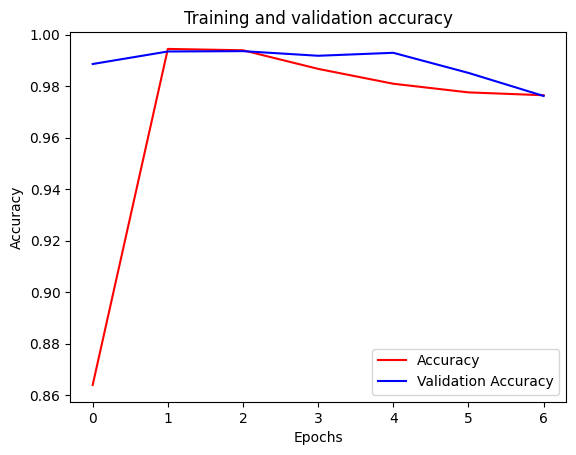

<Figure size 640x480 with 0 Axes>

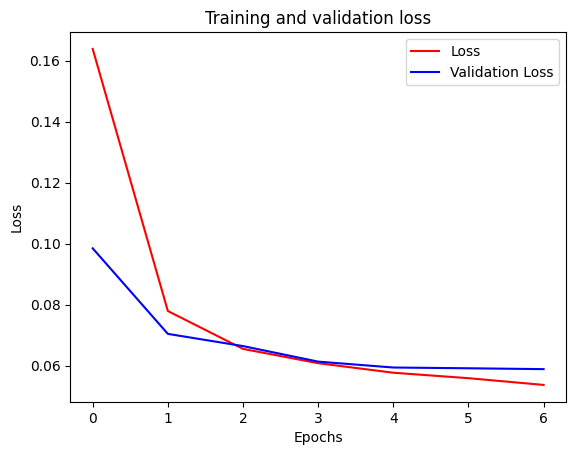

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt


#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()
plt.show()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()
plt.show()

#### Teste du modèle sur les données test, non utilisées lors de l'entrainement

In [ ]:
pred = model.predict(padded_seq_test)

748/748 [==============================] - 16s 21ms/step


In [ ]:
test_data.head(50)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
135587,d55d1ffa7a017d39,possible source benjiboi,0,0,0,0,0,0
135588,d55e1f07d2d5d30b,must say harrased much danny lilithborne think...,1,0,0,0,0,0
135589,d55e551ae2ca9b41,doh greetings whom may concern would appear th...,0,0,0,0,0,0
135590,d55eb7eb62909092,this may right time move article thanks watchi...,0,0,0,0,0,0
135591,d55ee43bc3a2778d,doing references means correct page numbers sh...,0,0,0,0,0,0
135592,d55fa1fefcbdaaab,havnt made edits like sockpuppets person block...,0,0,0,0,0,0
135593,d560f1c85d38da4d,wiki nazi tell stay cool asshole,1,0,1,0,1,1
135594,d5615d4409742350,certain done especially adding reference can e...,0,0,0,0,0,0
135595,d56343fd6b5c000a,agree think companionsmediaspecific encycloped...,0,0,0,0,0,0
135596,d56562d2d71b8da5,unfortunately ladefogeds sowl cannot recall of...,0,0,0,0,0,0


In [ ]:
test2 = test_data.copy()

In [ ]:
test2[classes] = pred


In [ ]:
test2.head(50)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
135587,d55d1ffa7a017d39,possible source benjiboi,0.003002,0.000042,0.000672,0.000192,0.000682,0.000363
135588,d55e1f07d2d5d30b,must say harrased much danny lilithborne think...,0.103592,0.000684,0.016154,0.001489,0.022152,0.004501
135589,d55e551ae2ca9b41,doh greetings whom may concern would appear th...,0.005270,0.000454,0.005050,0.001376,0.003604,0.002482
135590,d55eb7eb62909092,this may right time move article thanks watchi...,0.002554,0.000038,0.000604,0.000185,0.000622,0.000324
135591,d55ee43bc3a2778d,doing references means correct page numbers sh...,0.002968,0.000041,0.000658,0.000199,0.000691,0.000328
135592,d55fa1fefcbdaaab,havnt made edits like sockpuppets person block...,0.007064,0.000079,0.001214,0.000300,0.001437,0.000506
135593,d560f1c85d38da4d,wiki nazi tell stay cool asshole,0.931977,0.054187,0.666314,0.024286,0.580056,0.084972
135594,d5615d4409742350,certain done especially adding reference can e...,0.003035,0.000042,0.000674,0.000200,0.000709,0.000331
135595,d56343fd6b5c000a,agree think companionsmediaspecific encycloped...,0.001669,0.000029,0.000486,0.000181,0.000457,0.000282
135596,d56562d2d71b8da5,unfortunately ladefogeds sowl cannot recall of...,0.003243,0.000053,0.000785,0.000264,0.000943,0.000299


In [ ]:
model.save('/content/drive/MyDrive/LSTM_Glove_project_nlp_model_train.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### Pipeline

**Création d'une fonction pour le prétraitement**:
Créez une fonction qui prend une phrase brute en entrée et effectue les étapes de prétraitement, notamment la tokenisation, le padding, etc.

**Création d'une fonction pour la classification**:
Créez une fonction qui prend la phrase prétraitée et utilise le modèle pour effectuer une classification.

**Création de la pipeline**:
Créez une fonction qui prend une phrase brute en entrée, utilise la fonction de prétraitement, puis la fonction de classification.

In [ ]:
def preprocess_text(text, tokenizer, max_length, padding_type, trunc_type):
    # Tokenization
    sequences = tokenizer.texts_to_sequences([text])
    # Padding
    padded_seq = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
    return padded_seq

def classify_text(model, preprocessed_text):
    prediction = model.predict(preprocessed_text)
    return prediction

def text_classification_pipeline(text, tokenizer, max_length, padding_type, trunc_type, model, classes):
    # Prétraitement
    preprocessed_text = preprocess_text(text, tokenizer, max_length, padding_type, trunc_type)

    # Classification
    prediction = classify_text(model, preprocessed_text)

    # Créez un dictionnaire avec les noms de colonnes et les résultats de la prédiction
    result_dict = {class_name: prediction[0, i] for i, class_name in enumerate(classes)}

    return result_dict

**Exemple d'utilisation de la pipeline**:
Utilisez la fonction text_classification_pipeline avec une phrase brute.

In [ ]:
raw_text = "Disgusting"
prediction_result = text_classification_pipeline(raw_text, tokenizer, max_length, padding_type, trunc_type, model, classes)

for class_name, result in prediction_result.items():
    print(f"{class_name}: {result}")

1/1 [==============================] - 0s 33ms/step
toxic: 0.8118398785591125
severe_toxic: 0.017195893451571465
obscene: 0.3821938633918762
threat: 0.011254101991653442
insult: 0.338594913482666
identity_hate: 0.047072965651750565
